In [1]:
!pip install langgraph
!pip install python-dotenv langchain[groq]

In [2]:
import os
from google.colab import userdata
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Set API key
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_KEY')

# Initialize LLM model
llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq")


In [3]:
print(llm.invoke("What is WLan").content)

WLAN stands for Wireless Local Area Network. It is a type of computer network that allows devices to connect to the internet or communicate with each other without the use of cables or wires. WLANs use radio waves to transmit data between devices, allowing for wireless connectivity and mobility.

WLANs typically use a device called a wireless access point (AP) to connect to a wired network, such as a router or a switch. The AP broadcasts a signal that devices can detect and connect to, allowing them to access the network and the internet.

Some common characteristics of WLANs include:

1. **Wireless connectivity**: Devices can connect to the network without using cables or wires.
2. **Mobility**: Users can move around while staying connected to the network.
3. **Broadcasting**: The AP broadcasts a signal that devices can detect and connect to.
4. **Security**: WLANs often use encryption and authentication protocols to secure data transmission.

WLANs are commonly used in a variety of s

In [6]:
from typing import TypedDict
from langgraph.graph import StateGraph, END, START
from IPython.display import display, Image

# This defines the structure for the data that will be passed between nodes in your graph.
# Each key represents a piece of information that can be updated during the process.
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [7]:
# --- Node functions ---
def categorize(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following query into one of the following categories: Technical, Billing, General. Query: {query}"
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"]}).content
    # Extract just the category word from the sentence
    # This assumes the category is always the last word after "as: " or similar
    category = category.split(':')[-1].strip().split('.')[0].strip()
    print(f"Category: {category}")
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following query. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state["query"]}).content
    print(f"Sentiment: {sentiment}")
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    print("Handling the technical query")
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    print("Handling the billing query")
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    print("Handling the general query")
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    print("Escalating Query")
    return {"response": "This query has been escalated to a human agent due to its negative sentiment"}

# --- Workflow setup ---
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Entry point
workflow.add_edge(START, "categorize")

# --- Conditional edges ---
# categorize → analyze_sentiment
workflow.add_edge("categorize", "analyze_sentiment")

# analyze_sentiment → conditional routing
workflow.add_conditional_edges(
    "analyze_sentiment",
    lambda state: (
        "escalate" if "negative" in state["sentiment"].lower()
        else state["category"].strip().lower()
    ),
    {
        "escalate": "escalate",
        "technical": "handle_technical",
        "billing": "handle_billing",
        "general": "handle_general",
    },
)

# Exit points
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Compile app
app = workflow.compile()

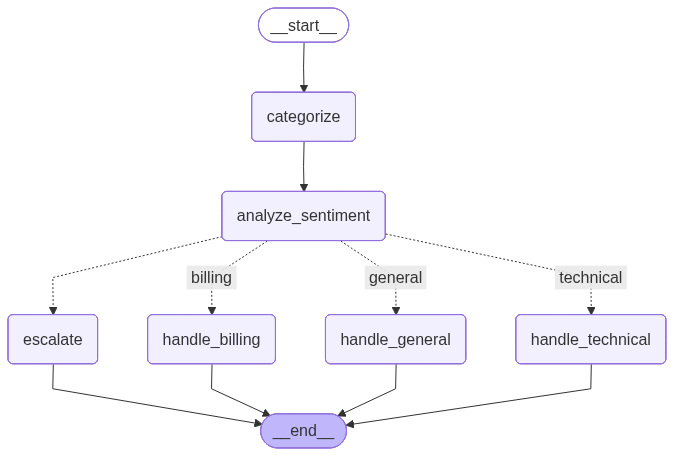

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Visualization error:", e)


In [9]:
result = app.invoke({"query": "My internet is not working"})
print("Final Output:", result)

Category: I would categorize the query as "Technical"
Sentiment: The sentiment of the query "My internet is not working" can be classified as negative. This is because the speaker is expressing frustration or inconvenience due to a problem with their internet connection, which is likely disrupting their daily activities or workflow. The tone is neutral in terms of emotional intensity, but the overall sentiment is clearly negative.
Escalating Query
Final Output: {'query': 'My internet is not working', 'category': 'I would categorize the query as "Technical"', 'sentiment': 'The sentiment of the query "My internet is not working" can be classified as negative. This is because the speaker is expressing frustration or inconvenience due to a problem with their internet connection, which is likely disrupting their daily activities or workflow. The tone is neutral in terms of emotional intensity, but the overall sentiment is clearly negative.', 'response': 'This query has been escalated to a h

In [10]:
def run_query(query: str) -> dict:
    # Run the workflow
    results = app.invoke({"query": query})

    # Return the structured result
    return {
        "query": query,
        "category": results.get("category", ""),
        "sentiment": results.get("sentiment", ""),
        "response": results.get("response", "")
    }

# --- Example usage ---
query = "The price value in my invoice is wrong"
result = run_query(query)

print("=== Result ===")
print(f"Query: {result['query']}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Category: I would categorize the query as "Billing"
Sentiment: The sentiment of the given query is neutral with a hint of frustration or concern. 

Here's a breakdown of the sentiment analysis:

- The phrase "The price value in my invoice is wrong" is a factual statement, which indicates a neutral tone.
- However, the phrase implies that there's an issue or an error, which might evoke feelings of frustration, concern, or disappointment in the speaker.
- The speaker's tone is likely to be inquiring or questioning, as they're bringing the issue to someone's attention, which suggests a neutral-to-concerned sentiment.

Overall, the sentiment of the query is not overtly negative or aggressive but rather seeking clarification or resolution to the issue.
Escalating Query
=== Result ===
Query: The price value in my invoice is wrong
Category: I would categorize the query as "Billing"
Sentiment: The sentiment of the given query is neutral with a hint of frustration or concern. 

Here's a breakdo

In [11]:
# Example query
query = "iphone isnt working"

# Run through workflow
result = run_query(query)

# Print nicely
print("=== Result ===")
print(f"Query: {result['query']}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Category: I would categorize the query "iphone isn't working" as a Technical query
Sentiment: The sentiment of the query "iphone isnt working" is negative. The phrase "isnt working" implies a problem or issue with the iPhone, which suggests frustration and possibly even anger or disappointment. The lack of specific details or context in the query also implies a sense of urgency or desperation, as the person is seeking help to resolve the issue. Overall, the sentiment is one of frustration or annoyance.
Escalating Query
=== Result ===
Query: iphone isnt working
Category: I would categorize the query "iphone isn't working" as a Technical query
Sentiment: The sentiment of the query "iphone isnt working" is negative. The phrase "isnt working" implies a problem or issue with the iPhone, which suggests frustration and possibly even anger or disappointment. The lack of specific details or context in the query also implies a sense of urgency or desperation, as the person is seeking help to res

In [12]:
# First query: product issue
query1 = "I purchased the iPhone 16 but its screen is broken."
result1 = run_query(query1)

print("=== Result 1 ===")
print(f"Query: {result1['query']}")
print(f"Category: {result1['category']}")
print(f"Sentiment: {result1['sentiment']}")
print(f"Response: {result1['response']}")
print("\n")

# Second query: negative sentiment complaint
query2 = "This is not the kind of service I was expecting?"
result2 = run_query(query2)

print("=== Result 2 ===")
print(f"Query: {result2['query']}")
print(f"Category: {result2['category']}")
print(f"Sentiment: {result2['sentiment']}")
print(f"Response: {result2['response']}")


Category: Technical
Sentiment: The sentiment of the given query is negative. The user is expressing a problem with their iPhone 16, specifically that its screen is broken. This indicates dissatisfaction with the product's performance or quality, which contributes to the negative sentiment.
Escalating Query
=== Result 1 ===
Query: I purchased the iPhone 16 but its screen is broken.
Category: Technical
Sentiment: The sentiment of the given query is negative. The user is expressing a problem with their iPhone 16, specifically that its screen is broken. This indicates dissatisfaction with the product's performance or quality, which contributes to the negative sentiment.
Response: This query has been escalated to a human agent due to its negative sentiment


Category: I would categorize the query as "General"
Sentiment: The sentiment of the query is negative. The speaker is expressing dissatisfaction with the service they received, suggesting that it did not meet their expectations. The phr

In [15]:
# Query: positive + invoice request
query = "I am really happy with the service and I want invoice for my new purchase"
result = run_query(query)

print("=== Result ===")
print(f"Query: {result['query']}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")


Category: Billing
Sentiment: The sentiment of the query is overwhelmingly positive. The phrase "I am really happy" explicitly conveys a positive emotion, indicating satisfaction with the service received. The fact that the person is asking for an invoice for their new purchase also suggests confidence and a legitimate transaction, further reinforcing a positive sentiment. The tone is polite and courteous, indicating a high level of satisfaction with the purchase and the service.
Handling the billing query
=== Result ===
Query: I am really happy with the service and I want invoice for my new purchase
Category: Billing
Sentiment: The sentiment of the query is overwhelmingly positive. The phrase "I am really happy" explicitly conveys a positive emotion, indicating satisfaction with the service received. The fact that the person is asking for an invoice for their new purchase also suggests confidence and a legitimate transaction, further reinforcing a positive sentiment. The tone is polite

In [14]:
# Query: general information
query = "is the new launch"
result = run_query(query)

print("=== Result ===")
print(f"Query: {result['query']}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Category: General
Sentiment: The sentiment of the query "Is the new launch" is neutral or ambivalent. It doesn't express a clear emotion or opinion, and it's more of a question to gather information rather than express a sentiment. The lack of adjectives or emotive language suggests that the query is neutral and doesn't convey a specific sentiment.
Handling the general query
=== Result ===
Query: is the new launch
Category: General
Sentiment: The sentiment of the query "Is the new launch" is neutral or ambivalent. It doesn't express a clear emotion or opinion, and it's more of a question to gather information rather than express a sentiment. The lack of adjectives or emotive language suggests that the query is neutral and doesn't convey a specific sentiment.
Response: It sounds like you're asking about a new launch, but could you please provide more context or information about what you're referring to? I'd be happy to help if you can provide more details about the launch you're intere